#Mise en œuvre de l'opérateur Ultimate Opening avec Maxtree



---



Mustafa SENOL - mustafa.senol@etu.unistra.fr

Emin SULTANOV - emin.sultanov@etu.unistra.fr

In [1]:
# Décommentez cette partie au cas où ce script ne sera pas utilisé localement (sur l'ordinateur).

# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/Colab\ Notebooks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from skimage.morphology import max_tree
from skimage import io
import networkx as nx
import copy

/home/oops/.local/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


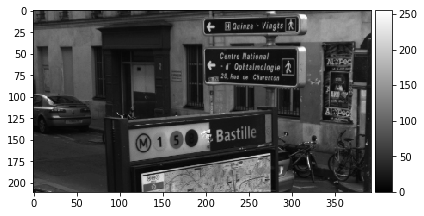

In [3]:
# Chargement des images d'exemple

img = io.imread('./test.png', as_gray = True) * 255
img = img.astype(np.int64)

# Example image based on the Figure 4 in the paper
# img = np.array([[75, 75, 75, 75, 75, 75, 75, 75, 175, 175],
#                 [75, 75, 75, 75, 75, 75, 75, 175, 175, 175],
#                 [75, 75, 75, 75, 75, 75, 75, 175, 175, 75],
#                 [75, 75, 75, 75, 75, 75, 75, 75, 75, 75],
#                 [75, 75, 75, 75, 75, 225, 225, 75, 75, 75],
#                 [75, 95, 95, 235, 95, 225, 225, 75, 75, 75],
#                 [95, 95, 235, 235, 235, 95, 95, 75, 75, 75],
#                 [95, 95, 235, 235, 235, 95, 95, 75, 75, 75],
#                 [75, 95, 95, 235, 95, 95, 75, 75, 75, 75],
#                 [75, 75, 75, 75, 75, 75, 75, 75, 75, 75]], dtype=np.uint8)

io.imshow(img, cmap="gray", vmax = 255, vmin = 0)

Le maxtree est une structure de données qui représente l'image par un arbre. Un nœud de niveau l est lié à un sous-ensemble de pixels de niveau l dans l'image. Ces pixels doivent être reliés entre eux par des pixels posés à un niveau supérieur ou égal à l.

Dans ce projet, nous avons utilisé le maxtree de scikit image library car la tâche principale du projet était d'implémenter Ultimate Opening avec l'aide de maxtree. Cette solution nous a permis d'accélérer le processus de mise en œuvre.

In [4]:
# Toutes les fonctions sont copiées de https://scikit-image.org/docs/dev/auto_examples/developers/plot_max_tree.html. Quelque fonctions sont légèrement modifiées.
# Ceci a été fait car le professeur a autorisé l'utilisation de la méthode maxtree déjà implémentée.

def plot_img(ax, image, title, plot_text, image_values):
    """Plot an image, overlaying image values or indices."""
    ax.imshow(image, cmap='gray', aspect='equal', vmin=0, vmax=np.max(image))
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])

    for x in np.arange(-0.5, image.shape[0], 1.0):
        ax.add_artist(Line2D((x, x), (-0.5, image.shape[0] - 0.5),
                             color='blue', linewidth=2))

    for y in np.arange(-0.5, image.shape[1], 1.0):
        ax.add_artist(Line2D((-0.5, image.shape[1]), (y, y),
                             color='blue', linewidth=2))

    if plot_text:
        for i, j in np.ndindex(*image_values.shape):
            ax.text(j, i, image_values[i, j], fontsize=8,
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='red')
    return


def prune(G, node, res):
    """Transform a canonical max tree to a max tree."""
    value = G.nodes[node]['value']
    res[node] = str(node)
    preds = [p for p in G.predecessors(node)]
    for p in preds:
        if (G.nodes[p]['value'] == value):
            res[node] += ', %i' % p
            G.remove_node(p)
        else:
            prune(G, p, res)
    G.nodes[node]['label'] = res[node]
    return


def accumulate(G, node, res):
    """Transform a max tree to a component tree."""
    total = G.nodes[node]['label']
    parents = G.predecessors(node)
    for p in parents:
        total += ', ' + accumulate(G, p, res)
    res[node] = total
    return total


def position_nodes_for_max_tree(G, image_rav, root_x=4, delta_x=1.2):
    """Set the position of nodes of a max-tree.

    This function helps to visually distinguish between nodes at the same
    level of the hierarchy and nodes at different levels.
    """
    pos = {}
    for node in reversed(list(nx.topological_sort(canonical_max_tree))):
        value = G.nodes[node]['value']
        if canonical_max_tree.out_degree(node) == 0:
            # root
            pos[node] = (root_x, value)

        in_nodes = [y for y in canonical_max_tree.predecessors(node)]

        # place the nodes at the same level
        level_nodes = [y for y in
                       filter(lambda x: image_rav[x] == value, in_nodes)]
        nb_level_nodes = len(level_nodes) + 1

        c = nb_level_nodes // 2
        i = - c
        if (len(level_nodes) < 3):
            hy = 0
            m = 0
        else:
            hy = 0.25
            m = hy / (c - 1)

        for level_node in level_nodes:
            if(i == 0):
                i += 1
            if (len(level_nodes) < 3):
                pos[level_node] = (pos[node][0] + i * 0.6 * delta_x, value)
            else:
                pos[level_node] = (pos[node][0] + i * 0.6 * delta_x,
                                   value + m * (2 * np.abs(i) - c - 1))
            i += 1

        # place the nodes at different levels
        other_level_nodes = [y for y in
                             filter(lambda x: image_rav[x] > value, in_nodes)]
        if (len(other_level_nodes) == 1):
            i = 0
        else:
            i = - len(other_level_nodes) // 2
        for other_level_node in other_level_nodes:
            if((len(other_level_nodes) % 2 == 0) and (i == 0)):
                i += 1
            pos[other_level_node] = (pos[node][0] + i * delta_x,
                                     image_rav[other_level_node])
            i += 1

    return pos


def plot_tree(graph, positions, ax, *, title='', labels=None,
              font_size=8, text_size=8):
    """Plot max and component trees."""
    nx.draw_networkx(graph, pos=positions, ax=ax, node_size=40, node_shape='s', node_color='white', font_size=font_size, labels=labels)
    xlimit = ax.get_xlim()
    a = [x[1] for x in np.array(list(positions.items()))[:,1]]
    

    for v in reversed(range(image_rav.min(), image_rav.max() + 1)):
        if (v in a):
            ax.text(-3, v - 0.15, "val: %i" % v, fontsize=text_size)
    ax.set_xlim(-3, 10)
    ax.set_title(title)
    ax.set_axis_off()

In [5]:
P,S = max_tree(img)
P_rav = P.ravel()

# image altérée
image_rav = img.ravel()

# indices dégradés de l'image d'exemple (à des fins d'affichage)
raveled_indices = np.arange(img.size).reshape(img.shape)

# Décommenter pour montrer les résultats du processus ci-dessous

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9, 3))
# plot_img(ax1, img - img.min(), 'Image Values',
#          plot_text=True, image_values=img)
# plot_img(ax2, img - img.min(), 'Raveled Indices',
#          plot_text=True, image_values=raveled_indices)
# plot_img(ax3, img - img.min(), 'Max-tree indices',
#          plot_text=True, image_values=P)

In [6]:
image_rav = img.ravel()
raveled_indices = np.arange(img.size).reshape(img.shape)

# le graphe canonique max-tree
canonical_max_tree = nx.DiGraph()
canonical_max_tree.add_nodes_from(S)
for node in canonical_max_tree.nodes():
    canonical_max_tree.nodes[node]['value'] = image_rav[node]
canonical_max_tree.add_edges_from([(n, P_rav[n]) for n in S[1:]])

# max-tree à partir du max-tree canonique
nx_max_tree = nx.DiGraph(canonical_max_tree)
labels = {}
prune(nx_max_tree, S[0], labels)

# positions des nœuds : canonical max-tree (CMT)
pos_cmt = position_nodes_for_max_tree(canonical_max_tree, image_rav)
# positions des noeuds : max-tree (MT)
pos_mt = dict(zip(nx_max_tree.nodes, [pos_cmt[node] for node in nx_max_tree.nodes]))

# Décommenter pour tracer les arbres avec networkx et matplotlib
# fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(30, 10))
# plot_tree(nx_max_tree.reverse(), pos_mt, ax1, title='Max tree', labels=labels)
# fig.tight_layout()
# plt.show()

In [7]:
# Conversion de la relation entre les nœuds parents et les nœuds enfants de la manière décrite dans l'article. 
# En général : chaque parent a un enfant qui peut avoir plus d'un nœud frère.

relations = np.array(list((nx_max_tree.reverse().edges)))

son = {}
brother = {}
parent = relations[0,0]
brothers = list()
r = 0
while (r < relations.shape[0]):
    if (relations[r][0] == parent):
        if (parent not in son):
            son[parent] = relations[r][1]
        else:
            brother[relations[r-1][1]] = relations[r][1]
        r += 1
    else:
        parent = relations[r][0]

Comme décrit dans le papier :  "L'attribut que nous avons choisi est la hauteur de la composante connectée, définie comme la différence maximale de coordonnées verticales entre les pixels qui appartiennent à la composante connectée". Ainsi, nous calculons également l'attribut pour chaque composant de cette manière. 

In [8]:
# Calcul des attributs (hauteur de chaque composant)

def get_node_height (labels, node):
    """
    Calcul de hauteur d'un composant(nœud)
    """
    pixel_list = labels[node].split(', ')
    map_object = map(int, pixel_list)
    list_of_pixels = list(map_object)

    rows = [np.where(raveled_indices == n)[0][0] for n in list_of_pixels]
    return max(rows)-min(rows) + 1

def get_attributes (labels, tree):
    """
    Calcul de hauteurs de chaque composant
    """
    attributes = []
    for node in tree.nodes:
        attributes.append(get_node_height(labels, node))
    return attributes

att = get_attributes(labels, nx_max_tree)
attributes = {}

# Since the attribute of the first ancestor should be equal to 0
for i,node in enumerate(nx_max_tree.nodes):
    if att[i] == img.shape[0]:
        attributes[node] = 0
    else:
        attributes[node] = att[i]


Implémentation de la fonction compute_uo décrite dans le papier

In [9]:
transform_node_LUT = copy.deepcopy(attributes)
associated_node_LUT = copy.deepcopy(attributes)

def compute_uo (node, max_tr, max_in, parent_attribute, parent_value, previous_value, attributes, raveled_indices, img):
    """
    Calcul de Ultimate Opening. Fonction modifie la transform_node_LUT au maximum du résidu de chaque composant 
    ainsi que la associated_node_LUT, la taille de l'attribut d'ouverture associé au résidu maximum. 
    * node: current node
    * max_tr: the maximum contrast of the previous node (max value between the pixels of the node)
    * max_in: the attribute that generate max_tr (height in our case)
    * parent_attribute: the attribute of the parent node (height of the parent node)
    * parent_value: the value of the parent node (grayscale value)
    * previous_value: the value of the 1st ancestor with a different attribute: the parent of the branch

    
    """
    contrast = 0
    if (attributes[node]==parent_attribute):
        pixel_level = img[np.where(raveled_indices == node)][0]
        contrast = pixel_level - previous_value
    else:
        pixel_level = img[np.where(raveled_indices == node)][0]
        contrast = pixel_level - parent_value

    if (contrast >= max_tr):
        max_contrast = contrast
        linked_attributes = attributes[node];
    else:
        max_contrast = max_tr;
        linked_attributes = max_in;
    
    transform_node_LUT[node]=max_contrast;
    associated_node_LUT[node]=linked_attributes+1;

    if(node in son):
        child=son[node]
    else:
        child = -1
    
    if (attributes[node]==parent_attribute):
        pv = previous_value
    else:
        pv = parent_value
    
    while (child!=-1):
        compute_uo(child, max_contrast, linked_attributes, attributes[node], img[np.where(raveled_indices == node)][0], pv, attributes, raveled_indices, img)
        if (child in brother):
            child = brother[child]
        else:
            child = -1

# Au début quelque valeurs d'éntrée sont égales à 0 car au début il n'y a pas de nœud précédent 
compute_uo(list(nx_max_tree.nodes)[0], 0, 0, 0, 0, 0, attributes, raveled_indices, img)

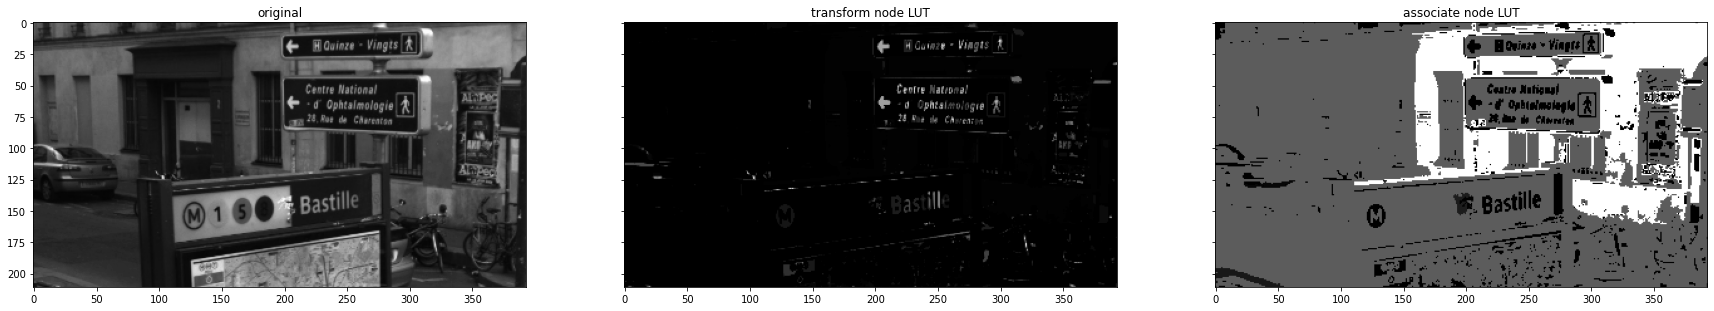

In [10]:
transform = copy.deepcopy(img)
associate = copy.deepcopy(img)

for r in range(img.shape[0]):
    for c in range(img.shape[1]):
        transform[r][c]=transform_node_LUT[P[r][c]]
        associate[r][c]=associated_node_LUT[P[r][c]]
        
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(30, 10))

ax1.set_title('original')
ax2.set_title('transform node LUT')
ax3.set_title('associate node LUT')

ax1.imshow(img, cmap="gray", vmax = 255, vmin = 0)
ax2.imshow(transform, cmap="gray")
ax3.imshow(associate, cmap="gray")